<a href="https://colab.research.google.com/github/uprestel/AutoNeRF/blob/master/Sheet%203/qda-lda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FML Exercise 2

## 1 Data Preparation

In [1]:
from sklearn.datasets import load_digits
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
digits = load_digits ()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [2]:


ind = np.logical_or(target==1, target==7)
data_filtered = data[ind]
target_filtered = target[ind]

print("number of instances in the filtered dataset:", target_filtered.shape)

X_train , X_test , y_train , y_test =\
model_selection.train_test_split(data_filtered, target_filtered,
test_size = 1./3, random_state = 0)


number of instances in the filtered dataset: (361,)


The filtered dataset indeed has 361 instances.

### 1.1 Dimension Reduction

First we examine the mean images for each class

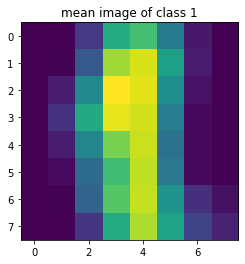

In [3]:
data_1 = data_filtered[target_filtered==1]
mean_1 = data_1.mean(axis=0).reshape(8,8)
plt.imshow(mean_1)
plt.title("mean image of class 1")
plt.show()

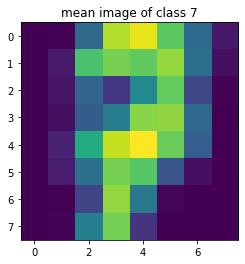

In [4]:
data_7 = data_filtered[target_filtered==7]
mean_7 = data_7.mean(axis=0).reshape(8,8)
plt.imshow(mean_7)
plt.title("mean image of class 7")
plt.show()

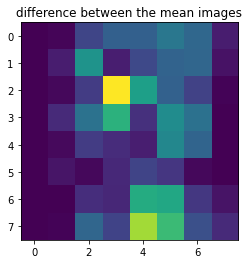

In [5]:
diff=np.abs(mean_7 - mean_1)
plt.imshow(diff)
plt.title("difference between the mean images")
plt.show()

What we are doing now is automated feature search. The idea is that we find the $m$ pixels where the difference between the mean images is the greatest. These pixels then can be used to distinguish the two classes later on very easily.

In this case we chose to find $m=10$ such pixels. We then output the pixels in decending order

In [6]:
n_biggest_components = 10

diff_current = diff
for i in range(n_biggest_components):
    index = np.argmax(diff_current)
    index_2d = np.unravel_index(index, diff_current.shape)
    print(f"feature {i} is pixel {index} with index {index_2d}")
    diff_current[index_2d] = 0


feature 0 is pixel 19 with index (2, 3)
feature 1 is pixel 60 with index (7, 4)
feature 2 is pixel 61 with index (7, 5)
feature 3 is pixel 27 with index (3, 3)
feature 4 is pixel 52 with index (6, 4)
feature 5 is pixel 53 with index (6, 5)
feature 6 is pixel 20 with index (2, 4)
feature 7 is pixel 10 with index (1, 2)
feature 8 is pixel 29 with index (3, 5)
feature 9 is pixel 37 with index (4, 5)


Let's say that the pixels from the previous set are denoted by $f_1, \dots , f_{10}$

The two features $F_1, F_2$ are then simply

\begin{align*}
F_1 &= \sum_{i=1}^5 f_i \\
F_2 &= \sum_{i=6}^{10} f_i \\
\end{align*}

In [7]:
def sum_over_index(x, index):
    s = 0
    for idx in index:
        s += x[idx]

    return s


def reduce_dim(x):
    """
        dimension reduction
        x: #instances x 64
        output: #instances x 2
         
    """
    n_instances = x.shape[0]
    reduced_dim = np.zeros((n_instances, 2))

    for i in range(n_instances):
        f1 = sum_over_index(x[i], [19 ,60 ,61 ,27 ,52 ])
        f2 = sum_over_index(x[i], [53 ,20 ,10 ,29 ,37 ])
        reduced_dim[i] = np.array([f1, f2])
    return reduced_dim

### 1.2 Scatterplot

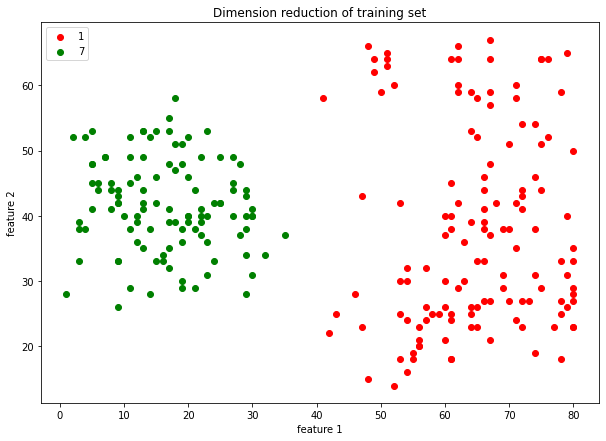

In [8]:
red_train = reduce_dim(X_train)

red_1_train = red_train[y_train == 1]
red_7_train = red_train[y_train == 7]

plt.figure(figsize=(10, 7))
plt.scatter(red_1_train[:,0], red_1_train[:,1], color="red", label="1")
plt.scatter(red_7_train[:,0], red_7_train[:,1], color="green", label="7")
plt.title("Dimension reduction of training set")
plt.legend(loc="upper left")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

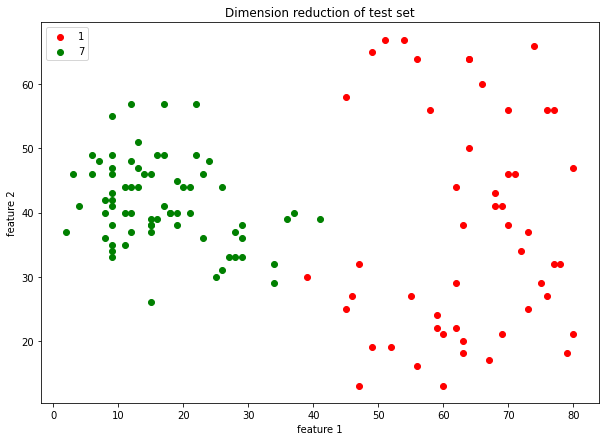

In [9]:
red_test = reduce_dim(X_test)

red_1_test = red_test[y_test == 1]
red_7_test = red_test[y_test == 7]

plt.figure(figsize=(10, 7))
plt.scatter(red_1_test[:,0], red_1_test[:,1], color="red", label="1")
plt.scatter(red_7_test[:,0], red_7_test[:,1], color="green", label="7")
plt.title("Dimension reduction of test set")
plt.legend(loc="upper left")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

## 2 Nearest Mean

### 2.1 Implement the nearest mean classifier

In [10]:
def nearest_mean(training_features, training_labels, test_features):
    
    training_mean_1 = training_features[training_labels==1].mean(axis=0)
    training_mean_7 = training_features[training_labels==7].mean(axis=0)
    distances_1 = np.linalg.norm(training_mean_1 - test_features, 2,axis=1)
    distances_7 = np.linalg.norm(training_mean_7 - test_features, 2,axis=1)
    distances = np.vstack([distances_1, distances_7]).T
    #print(distances.shape)
    predicted_label_index = np.argmin(distances, axis=1)
    #print(predicted_labels.shape)
    #print(predicted_label_index)
    predicted_labels = np.where(predicted_label_index == 0, 1, 7)
    #print(predicted_labels)
    return predicted_labels


#predicted_labels = nearest_mean(red_train, y_train, red_test)
#print(red_test.shape)

### 2.2 Visualize the decision regions

The decision region is an image of size (670, 800)


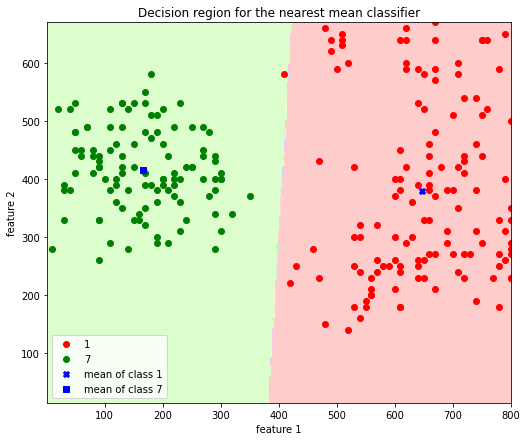

In [11]:
xmax = max(red_1_train[:,0].max(),red_7_train[:,0].max())
xmin = min(red_1_train[:,0].min(),red_7_train[:,0].min())
ymax = max(red_1_train[:,1].max(),red_7_train[:,1].max())
ymin = min(red_1_train[:,1].min(),red_7_train[:,1].min())

sizex, sizey = (xmax,ymax)


# We introduce a scale parameter to scale up the resolution of the 
# decision region.
scale = 10
nx, ny = (int(sizex*scale), int(sizey*scale))



x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
xv, yv = np.meshgrid(x, y)
XYpairs = np.dstack([xv, yv]).reshape(-1, 2)

predicted_labels = nearest_mean(red_train, y_train, XYpairs)
decision_region = predicted_labels.reshape(ny,nx)
print(f"The decision region is an image of size {decision_region.shape}")


training_mean_1 = red_1_train.mean(axis=0)
training_mean_7 = red_7_train.mean(axis=0)


plt.figure(figsize=(10, 7))
# Remark: We use a negative sign to flip the colors in the color scheme
plt.imshow(-decision_region, alpha=0.2, cmap="prism_r")
plt.scatter(red_1_train[:,0]*scale, red_1_train[:,1]*scale, color="red", label="1")
plt.scatter(red_7_train[:,0]*scale, red_7_train[:,1]*scale, color="green", label="7")
plt.scatter(training_mean_1[0]*scale,training_mean_1[1]*scale, color="blue", marker="X", label="mean of class 1")
plt.scatter(training_mean_7[0]*scale,training_mean_7[1]*scale, color="blue", marker="s", label="mean of class 7")


plt.xlim(xmin, xmax*scale)
plt.ylim(ymin, ymax*scale)
plt.title("Decision region for the nearest mean classifier")
plt.legend(loc="best")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

## 3 QDA


### 3.1 Implement QDA Training

In [12]:
def relabel(targets):
    """
        Helper function. As menstioned on the exercise sheet, 
        we relabel "1" to 0 and "7" to 1
    """
    labels = targets.copy()
    labels[labels==1]=0
    labels[labels==7]=1
    return labels

def fit_qda(training_features, training_labels): 

    N = training_labels.shape[0]    
    D = training_features.shape[1]


    mu = np.zeros((2,D))
    covmat = np.zeros((2,D,D))
    p = np.zeros(2)

    for label in [0,1]:

        data = training_features[training_labels == label]

        mean = np.mean(data, axis=0)
        mu[label, :] = mean

        covmat[label,:,:] = np.cov(data.T)

        # Prior
        prior = data.shape[0]/training_features.shape[0]
        p[label] = prior
    return mu, covmat, p


### 3.2 Implement QDA Prediction

In [13]:
def log_likelihood(x, mu, cov, p):
    logp = np.log(p)
    logfactor = - 0.5 * np.log(2 * np.pi * np.linalg.det(cov))
    logexp = -0.5 * (np.sum( (x - mu).T * np.dot(np.linalg.inv(cov), (x - mu).T), axis=0))
    loglikelihood = logfactor + logexp + logp
    return loglikelihood



def predict_qda(mu, cov, p, test_features):
    """
    This function returns the QDA predictions given
    input test_features: N_test x 2 numpy array 
    output: test_predictions: N_test numpy array
    """ 
    loglikelihood = np.zeros((test_features.shape[0], len(mu)))
    
    for label in range(len(mu)):
        loglikelihood_k = log_likelihood(test_features,mu[label],cov[label],p[label])
        loglikelihood[:, label] = loglikelihood_k

    index = np.argmax(loglikelihood, axis=-1)
    return index#np.where(index==1, 7, 1)

In [14]:
mu, cov, p = fit_qda(red_train, relabel(y_train))

predicted_labels_test = predict_qda(mu, cov, p, red_test)
test_accuracy = np.mean(predicted_labels_test == relabel(y_test))
print(f"Test accuracy of QDA: {test_accuracy*100} %")

predicted_labels_train = predict_qda(mu, cov, p, red_train)
training_accuracy = np.mean(predicted_labels_train == relabel(y_train))
print(f"Training accuracy of QDA: {training_accuracy*100} %")


Test accuracy of QDA: 99.17355371900827 %
Training accuracy of QDA: 100.0 %


### 3.3 Visualization

The decision region is an image of size (670, 800)


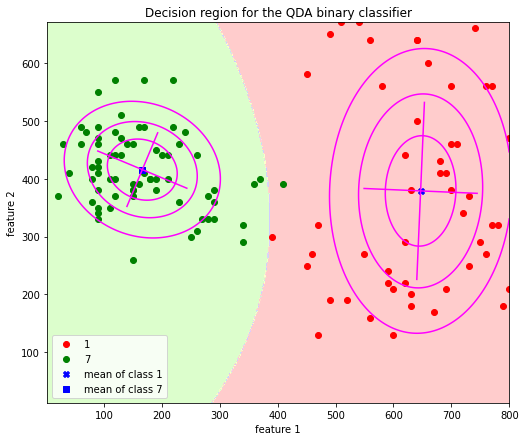

In [15]:

def plot_ellipse_axis(mu, cov, color="blue"):
    """
    This function plots the main axis of the distribution given mean and covariance matrix
    """
    
    # Eigenvalues/Eigenvector decomposition
    [lamb1, lamb2], [vec_1, vec_2] = np.linalg.eig(cov)
    lamb1, lamb2 = np.sqrt(lamb1), np.sqrt(lamb2)
    
    # Plot axis 1
    x1, y1 = ([mu[0] - lamb1*vec_1[0], mu[0] + lamb1*vec_1[0]],
              [mu[1] - lamb1*vec_2[0], mu[1] + lamb1*vec_2[0]])
    print(x1)
    plt.plot(x1, y1, color)
    
    # Plot axis 2
    x2, y2 = ([mu[0] - lamb2*vec_1[1], mu[0] + lamb2*vec_1[1]],
              [mu[1] - lamb2*vec_2[1], mu[1] + lamb2*vec_2[1]])
    plt.plot(x2, y2, color)


def plot_line(mu, cov, scale, eigve1,eigve2,x,lambd,color="blue"):
    print(mu, eigve1)
    x, y = (np.array([mu[0] - lambd*eigve1[0], mu[0] + lambd*eigve1[0]])*scale,
            np.array([mu[1] - lambd*eigve2[0], mu[1] + lambd*eigve2[0]])*scale)
    #print(x1)
    plt.plot(x, y, color)


def plot_ellipse_axis2(mu, cov, scale, color="blue"):
    """
    This function plots the main axis of the distribution given mean and covariance matrix
    """
    
    [eigva1, eigva2], [eigve1, eigve2] = np.linalg.eig(cov)
    lambda1, lambda2 = np.sqrt(eigva1), np.sqrt(eigva2)
    
    x1, y1 = (np.array([mu[0] - lambda1*eigve1[0], mu[0] + lambda1*eigve1[0]])*scale,
              np.array([mu[1] - lambda1*eigve2[0], mu[1] + lambda1*eigve2[0]])*scale)
    print(x1)
    plt.plot(x1, y1, color)


def plot_ellipse_axis3(mu, cov, scale, color="magenta"):
    """
    This function plots the main axis of the distribution given mean and covariance matrix
    """
    
    eigva, eigve = np.linalg.eig(cov)
    lambd = np.sqrt(eigva)
    
    x1, y1 = (np.array([mu[0] - lambd[0]*eigve[0,0], mu[0] + lambd[0]*eigve[0,0]])*scale,
              np.array([mu[1] - lambd[0]*eigve[1,0], mu[1] + lambd[0]*eigve[1,0]])*scale)
    plt.plot(x1, y1, color)

    x2, y2 = (np.array([mu[0] - lambd[1]*eigve[0,1], mu[0] + lambd[1]*eigve[0,1]])*scale,
              np.array([mu[1] - lambd[1]*eigve[1,1], mu[1] + lambd[1]*eigve[1,1]])*scale)
    plt.plot(x2, y2, color)

    


xmax = max(red_1_test[:,0].max(),red_7_test[:,0].max())
xmin = min(red_1_test[:,0].min(),red_7_test[:,0].min())
ymax = max(red_1_test[:,1].max(),red_7_test[:,1].max())
ymin = min(red_1_test[:,1].min(),red_7_test[:,1].min())

sizex, sizey = (xmax,ymax)


# We introduce a scale parameter to scale up the resolution of the 
# decision region.
scale = 10
nx, ny = (int(sizex*scale), int(sizey*scale))



x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
xv, yv = np.meshgrid(x, y)
XYpairs = np.dstack([xv, yv]).reshape(-1, 2)



mu, cov, p = fit_qda(red_train, relabel(y_train))
predicted_labels = predict_qda(mu, cov, p, XYpairs)
decision_region = predicted_labels.reshape(ny,nx)
print(f"The decision region is an image of size {decision_region.shape}")


training_mean_1 = red_1_train.mean(axis=0)
training_mean_7 = red_7_train.mean(axis=0)


plt.figure(figsize=(10, 7))
# Remark: We use a negative sign to flip the colors in the color scheme
plt.imshow(-decision_region, alpha=0.2, cmap="prism_r")
plt.scatter(red_1_test[:,0]*scale, red_1_test[:,1]*scale, color="red", label="1")
plt.scatter(red_7_test[:,0]*scale, red_7_test[:,1]*scale, color="green", label="7")
plt.scatter(training_mean_1[0]*scale,training_mean_1[1]*scale, color="blue", marker="X", label="mean of class 1")
plt.scatter(training_mean_7[0]*scale,training_mean_7[1]*scale, color="blue", marker="s", label="mean of class 7")

color="magenta"
z = np.exp(log_likelihood(XYpairs, mu[0], cov[0], p[0])).reshape(-1, 800)
plt.contour(x*scale, y*scale, z, 3, colors=color)
z = np.exp(log_likelihood(XYpairs, mu[1], cov[1], p[1])).reshape(-1, 800)
plt.contour(x*scale, y*scale, z, 3, colors=color)
plot_ellipse_axis3(mu[0], cov[0], scale)
plot_ellipse_axis3(mu[1], cov[1], scale)


plt.xlim(xmin, xmax*scale)
plt.ylim(ymin, ymax*scale)
plt.title("Decision region for the QDA binary classifier")
plt.legend(loc="best")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

### 3.4 Performance evaluation


In [28]:
from sklearn.model_selection import KFold



def cross_validation(fit_func, pred_func, n_folds=10):
    global data, target


    index = np.logical_or(target == 1, target == 7)
    cur_data = data[index]/data.max()
    targets = target[index]

    targets = relabel(targets)
    #print(targets.shape)

    k_folds = KFold(n_splits=n_folds)

    mean_accuracy = np.zeros(n_folds)
    for i, (train, test) in enumerate(k_folds.split(cur_data)):

        red_train, red_test = reduce_dim(cur_data[train]), reduce_dim(cur_data[test])
        mu, cov, p = fit_func(red_train, targets[train])

        predicted_labels = pred_func(mu, cov, p, red_test)
        correctly_predicted_labels = predicted_labels == targets[test]

        mean_accuracy[i] = np.mean(correctly_predicted_labels)
    
    return mean_accuracy.mean(), mean_accuracy.std()

In [29]:
mean, std = cross_validation(fit_qda, predict_qda, 10)
print(f"(Mean) accuracy via cross-validation is {mean*100} % with std {std*100} %")

(Mean) accuracy via cross-validation is 99.45195195195195 % with std 1.0962246417691845 %


## 4 LDA


### Implement LDA Training

In [36]:

def fit_lda(training_features, training_labels): 

    N = training_labels.shape[0]    
    D = training_features.shape[1]


    mu = np.zeros((2,D))
    covmat = np.zeros((D,D))
    p = np.zeros(2)

    for label in [0,1]:

        data = training_features[training_labels == label]

        mean = np.mean(data, axis=0)
        mu[label, :] = mean

        prior = data.shape[0]/training_features.shape[0]
        p[label] = prior

    covmat = np.cov(training_features.T)
    return mu, covmat, p



### Implement QDA Prediction

In [37]:

def predict_lda(mu, cov, p, test_features):
    loglikelihood = np.zeros((test_features.shape[0], len(mu)))
    
    for label in range(len(mu)):
        loglikelihood_k = log_likelihood(test_features,mu[label],cov,p[label])
        loglikelihood[:, label] = loglikelihood_k

    index = np.argmax(loglikelihood, axis=-1)
    return index#np.where(index==1, 7, 1)

### Visualization

The decision region is an image of size (670, 800)


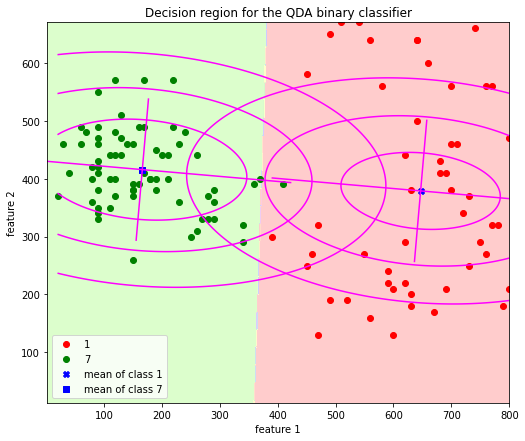

In [40]:

def plot_ellipse_axis(mu, cov, color="blue"):
    """
    This function plots the main axis of the distribution given mean and covariance matrix
    """
    
    # Eigenvalues/Eigenvector decomposition
    [lamb1, lamb2], [vec_1, vec_2] = np.linalg.eig(cov)
    lamb1, lamb2 = np.sqrt(lamb1), np.sqrt(lamb2)
    
    # Plot axis 1
    x1, y1 = ([mu[0] - lamb1*vec_1[0], mu[0] + lamb1*vec_1[0]],
              [mu[1] - lamb1*vec_2[0], mu[1] + lamb1*vec_2[0]])
    print(x1)
    plt.plot(x1, y1, color)
    
    # Plot axis 2
    x2, y2 = ([mu[0] - lamb2*vec_1[1], mu[0] + lamb2*vec_1[1]],
              [mu[1] - lamb2*vec_2[1], mu[1] + lamb2*vec_2[1]])
    plt.plot(x2, y2, color)


def plot_line(mu, cov, scale, eigve1,eigve2,x,lambd,color="blue"):
    print(mu, eigve1)
    x, y = (np.array([mu[0] - lambd*eigve1[0], mu[0] + lambd*eigve1[0]])*scale,
            np.array([mu[1] - lambd*eigve2[0], mu[1] + lambd*eigve2[0]])*scale)
    #print(x1)
    plt.plot(x, y, color)


def plot_ellipse_axis2(mu, cov, scale, color="blue"):
    """
    This function plots the main axis of the distribution given mean and covariance matrix
    """
    
    [eigva1, eigva2], [eigve1, eigve2] = np.linalg.eig(cov)
    lambda1, lambda2 = np.sqrt(eigva1), np.sqrt(eigva2)
    
    x1, y1 = (np.array([mu[0] - lambda1*eigve1[0], mu[0] + lambda1*eigve1[0]])*scale,
              np.array([mu[1] - lambda1*eigve2[0], mu[1] + lambda1*eigve2[0]])*scale)
    print(x1)
    plt.plot(x1, y1, color)


def plot_ellipse_axis3(mu, cov, scale, color="magenta"):
    """
    This function plots the main axis of the distribution given mean and covariance matrix
    """
    
    eigva, eigve = np.linalg.eig(cov)
    lambd = np.sqrt(eigva)
    
    x1, y1 = (np.array([mu[0] - lambd[0]*eigve[0,0], mu[0] + lambd[0]*eigve[0,0]])*scale,
              np.array([mu[1] - lambd[0]*eigve[1,0], mu[1] + lambd[0]*eigve[1,0]])*scale)
    plt.plot(x1, y1, color)

    x2, y2 = (np.array([mu[0] - lambd[1]*eigve[0,1], mu[0] + lambd[1]*eigve[0,1]])*scale,
              np.array([mu[1] - lambd[1]*eigve[1,1], mu[1] + lambd[1]*eigve[1,1]])*scale)
    plt.plot(x2, y2, color)

    


xmax = max(red_1_test[:,0].max(),red_7_test[:,0].max())
xmin = min(red_1_test[:,0].min(),red_7_test[:,0].min())
ymax = max(red_1_test[:,1].max(),red_7_test[:,1].max())
ymin = min(red_1_test[:,1].min(),red_7_test[:,1].min())

sizex, sizey = (xmax,ymax)


# We introduce a scale parameter to scale up the resolution of the 
# decision region.
scale = 10
nx, ny = (int(sizex*scale), int(sizey*scale))



x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
xv, yv = np.meshgrid(x, y)
XYpairs = np.dstack([xv, yv]).reshape(-1, 2)



mu, cov, p = fit_lda(red_train, relabel(y_train))
predicted_labels = predict_lda(mu, cov, p, XYpairs)
decision_region = predicted_labels.reshape(ny,nx)
print(f"The decision region is an image of size {decision_region.shape}")


training_mean_1 = red_1_train.mean(axis=0)
training_mean_7 = red_7_train.mean(axis=0)


plt.figure(figsize=(10, 7))
# Remark: We use a negative sign to flip the colors in the color scheme
plt.imshow(-decision_region, alpha=0.2, cmap="prism_r")
plt.scatter(red_1_test[:,0]*scale, red_1_test[:,1]*scale, color="red", label="1")
plt.scatter(red_7_test[:,0]*scale, red_7_test[:,1]*scale, color="green", label="7")
plt.scatter(training_mean_1[0]*scale,training_mean_1[1]*scale, color="blue", marker="X", label="mean of class 1")
plt.scatter(training_mean_7[0]*scale,training_mean_7[1]*scale, color="blue", marker="s", label="mean of class 7")

color="magenta"
z = np.exp(log_likelihood(XYpairs, mu[0], cov, p[0])).reshape(-1, 800)
plt.contour(x*scale, y*scale, z, 3, colors=color)
z = np.exp(log_likelihood(XYpairs, mu[1], cov, p[1])).reshape(-1, 800)
plt.contour(x*scale, y*scale, z, 3, colors=color)
plot_ellipse_axis3(mu[0], cov, scale)
plot_ellipse_axis3(mu[1], cov, scale)


plt.xlim(xmin, xmax*scale)
plt.ylim(ymin, ymax*scale)
plt.title("Decision region for the QDA binary classifier")
plt.legend(loc="best")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

### Performance evaluation

In [44]:
mean, std = cross_validation(fit_lda, predict_lda, 10)
print(f"(Mean) accuracy of LDA via cross-validation is {mean*100} % with std {std*100} %")

(Mean) accuracy of LDA via cross-validation is 99.17417417417418 % with std 1.2616187109669668 %
